In [1]:
import openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from skopt.space import Real, Categorical, Integer

# 1. Przygotowanie danych

In [249]:
#datasets
1046 #mozilla4
1489 #phoneme
31 #credit-g
1067 #kc1
#43890
846

dataset_ids = [31, 1046, 1067, 1489]
N = len(dataset_ids)

### Funkcje pomocnicze

In [584]:
def fetch_datasets(dataset_ids):
    datasets = []
    for id in list(dataset_ids):
        dataset = openml.datasets.get_dataset(id)
        X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute) 
        datasets.append({"X": preprocess_X(X), "y": preprocess_y(y)})

    return datasets

def preprocess_y(y):
    if(y.dtype == "category"):
        return y.cat.codes
    if(y.dtype == "bool"):
        return y.astype(int)
    return y

def preprocess_X(X):
    categorical_columns = X.select_dtypes(include=['category']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), categorical_columns)
            #('num', SimpleImputer(strategy='mean'), ['NumericColumn'])  # You can add more numeric columns if needed
        ], remainder = "passthrough")

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
    ])

    # Fit and transform the data
    return pipeline.fit_transform(X)

def summarise_results(param_grid, search_procedure, N):
    df = pd.DataFrame({key: search_procedure[0].cv_results_[key].data for key in ["param_" + p for p in param_grid.keys()]})
    scores = np.stack([s.cv_results_["mean_test_score"] for s in search_procedure])
    df = pd.concat([df, pd.DataFrame(scores.T, columns = ["auc_" + str(i+1) for i in range(N)])], axis = 1)
    df['auc_avg'] = np.mean(scores, axis = 0)
    df.rename(columns={col: col.replace('param_', '') for col in df.columns}, inplace=True)
    
    return df

def best_params(df, n = None):
    if n is None:
        return df.loc[df['auc_avg'].idxmax()]
    else:
        return df.loc[df['auc_' + str(n)].idxmax()]
    
def calculate_tunability(random_search_results, N, best_par = None):

    if best_par is None:
        best_avg = best_params(random_search_results)
    else:
        best_avg = best_par

    tun = []
    for i in range(N):
        best_i_random = best_params(random_search_results, i+1)

        tun.append(best_i_random["auc_" + str(i+1)] - best_avg["auc_" + str(i+1)])

    return np.array(tun)

### Wczytanie danych

In [ ]:
data = fetch_datasets(dataset_ids)

### Siatka parametrów

In [147]:
param_grid_dt_disc = {'criterion': ["gini", "entropy"],
           'splitter': ["best", "random"],
           'max_depth': [None] + list(range(2, 33)),
           'min_samples_split': np.logspace(-4, -1, 10),
           #'min_samples_leaf': [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
           'min_impurity_decrease': np.logspace(-5, -1, 10),
           'ccp_alpha': np.logspace(-5, -1, 10)
           }

param_grid_rf_disc = {'criterion': ["gini", "entropy", "log_loss"],
                 "n_estimators": list(range(2, 501, 10)),
                  'max_depth': list(range(2, 33)),
                  'min_samples_split': np.logspace(-4, -1, 10),
                  #'min_samples_leaf': [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],
                  'max_features': ['sqrt', 'log2', None],
                  'min_impurity_decrease': np.logspace(-10, -1, 10)
           }

param_grid_xgb_disc = {"n_estimators": list(range(10, 1001, 10)),
                  'max_depth': list(range(2, 33)),
                  'subsample': np.linspace(0.5, 1, 10),
                  'colsample_bytree': np.linspace(0.5, 1, 10),
                  'gamma': np.logspace(-1, 0, 11),
                   'reg_alpha': np.logspace(-10, 3, 14),
                   'reg_lambda': np.logspace(-10, 3, 14)
           }

param_grid_dt = {'criterion': Categorical(["gini", "entropy"]),
           'splitter': Categorical(["best", "random"]),
           'max_depth': [None] + list(range(2, 33)),
           'min_samples_split': Real(0.0001, 0.1, prior = "log-uniform"),
           'min_impurity_decrease': Real(0.0001, 0.1, prior = "log-uniform"),
           'ccp_alpha': Real(0.0001, 0.1, prior = "log-uniform")
           }

param_grid_rf = {'criterion': Categorical(["gini", "entropy", "log_loss"]),
                 "n_estimators": Integer(2, 500),
                  'max_depth': Integer(2, 32),
                  'min_samples_split': Real(0.0001, 0.1, prior = "log-uniform"),
                  'max_features': Categorical(['sqrt', 'log2', None]),
                  'min_impurity_decrease': Real(1e-10, 1e-1, prior = "log-uniform"),
           }

param_grid_xgb = {"n_estimators": Integer(10, 1000),
                  'max_depth': Integer(2, 32),
                  #'min_child_weight': Real(1, 10),
                  'subsample': Real(0.5, 1),
                  'colsample_bytree': Real(0.5, 1),
                  'gamma': Real(1e-10, 1, prior = "log-uniform"),
                  'reg_alpha': Real(1e-10, 1e3, prior = "log-uniform"),
                  'reg_lambda': Real(1e-10, 1e3, prior = "log-uniform")
           }

# 2. Optymalizacja hiperparametrów

## 2.1 Przeszukiwanie losowe (RandomizedSearchCV)

### DecisionTreeClassifier

In [ ]:
random_search_dt = [RandomizedSearchCV(estimator = DecisionTreeClassifier(random_state=2023),
                   param_distributions = param_grid_dt_disc, random_state=2023, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 20, error_score = "raise") for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing random search on decision tree, dataset {i+1}")
    random_search_dt[i].fit(data[i]["X"], data[i]["y"])


### RandomForest

In [ ]:
random_search_rf = [RandomizedSearchCV(estimator = RandomForestClassifier(random_state=2023, n_jobs = 2),
                   param_distributions = param_grid_rf_disc, random_state=2023, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 10, error_score = "raise") for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing random search on RF, dataset {i+1}")
    random_search_rf[i].fit(data[i]["X"], data[i]["y"])

### XGBoost

In [ ]:
random_search_xgb = [RandomizedSearchCV(estimator = XGBClassifier(random_state=2023, learning_rate = 0.05),
                   param_distributions = param_grid_xgb_disc, random_state=2023, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 20, error_score = "raise") for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing random search on XGB, dataset {i+1}")
    random_search_xgb[i].fit(data[i]["X"], data[i]["y"])

### Zapisanie wyników

In [403]:
# import pickle

# data_to_save = {
#     "random_search_dt": random_search_dt,
#     "random_search_rf": random_search_rf,
#     "random_search_xgb": random_search_xgb
# }

# file_path = 'random_search_res250_4ds.pkl'
# with open(file_path, 'wb') as file:
#     pickle.dump(data_to_save, file)

dt_df = summarise_results(param_grid_dt, random_search_dt, N)
rf_df = summarise_results(param_grid_rf, random_search_rf, N)
xgb_df = summarise_results(param_grid_xgb, random_search_xgb, N)

## 2.2 Optymalizacja bayesowska (BayesSearchCV)

### Decision Tree

In [ ]:
bayes_search_dt = [BayesSearchCV(DecisionTreeClassifier(random_state=2023), 
                   param_grid_dt, random_state=2023, n_points = 1, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 5) for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing bayes search on DT, dataset {i+1}")
    bayes_search_dt[i].fit(data[i]["X"], data[i]["y"])

### RandomForest

In [227]:
bayes_search_rf = [BayesSearchCV(RandomForestClassifier(random_state=2023), 
                   param_grid_rf, random_state=2023, n_points = 1, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 5) for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing bayes search on random forest, dataset {i+1}")
    bayes_search_rf[i].fit(data[i]["X"], data[i]["y"])

### XGBoost

In [ ]:
#xgb_classifiers = [XGBClassifier(random_state=2023, learning_rate = 0.05, device = "gpu")]*len(dataset_ids)

bayes_search_xgb = [BayesSearchCV(XGBClassifier(random_state=2023, learning_rate = 0.05),#, device = "gpu"), 
                   param_grid_xgb, random_state=2023, n_points = 1, scoring = "roc_auc",
                   cv = 5, n_iter = 250, n_jobs = 5) for _ in range(len(dataset_ids))]

for i in range(len(dataset_ids)):
    print(f"Performing bayes search on xgboost, dataset {i+1}")
    bayes_search_xgb[i].fit(data[i]["X"], data[i]["y"])

### Zapisanie wyników

In [497]:
dt_df_b = summarise_results(param_grid_dt, bayes_search_dt, N)
rf_df_b = summarise_results(param_grid_rf, bayes_search_rf, N)
xgb_df_b = summarise_results(param_grid_xgb, bayes_search_xgb, N)

## 2.3 Optymalizacja jednowymiarowa (RandomizedSearchCV - de facto GridSearchCV)

In [440]:
#Obliczamy optymalne średnie parametry z wyszukiwania losowego
best_params_dt = best_params(dt_df).drop(dt_df.filter(like='auc', axis=1).columns)
best_params_rf = best_params(rf_df).drop(rf_df.filter(like='auc', axis=1).columns)
best_params_xgb = best_params(xgb_df).drop(xgb_df.filter(like='auc', axis=1).columns)

oneway_search_dt = dict.fromkeys(param_grid_dt.keys())
oneway_search_rf = dict.fromkeys(param_grid_rf.keys())
oneway_search_xgb = dict.fromkeys(param_grid_xgb.keys())

results_oneway_dt = {}
results_oneway_rf = {}
results_oneway_xgb = {}

### Decision Tree

In [ ]:
for p in param_grid_dt.keys():
    this_param = {key: value for key, value in param_grid_dt_disc.items() if key == p}
    other_params = {key: value for key, value in best_params_dt.items() if key != p}

    print(this_param)
    print(other_params)

    oneway_search_dt[p] = [RandomizedSearchCV(DecisionTreeClassifier(random_state=2023, **other_params), 
                    param_distributions = this_param, random_state=2023, scoring = "roc_auc",
                    cv = 5, n_iter = 50, n_jobs = 20) for _ in range(len(dataset_ids))]
    
    for i in range(len(dataset_ids)):
        print(f"Performing one-way search on DT, parameter: {p}, dataset {i+1}")
        oneway_search_dt[p][i].fit(data[i]["X"], data[i]["y"])

    results_oneway_dt[p] = summarise_results(this_param, oneway_search_dt[p], N)

### RandomForest

In [ ]:
for p in param_grid_rf.keys():
    this_param = {key: value for key, value in param_grid_rf_disc.items() if key == p}
    other_params = {key: value for key, value in best_params_rf.items() if key != p}

    print(this_param)
    print(other_params)

    oneway_search_rf[p] = [RandomizedSearchCV(RandomForestClassifier(random_state=2023, **other_params), 
                    param_distributions = this_param, random_state=2023, scoring = "roc_auc",
                    cv = 5, n_iter = 100, n_jobs = 20) for _ in range(len(dataset_ids))]
    
    for i in range(len(dataset_ids)):
        print(f"Performing one-way search on RF, parameter: {p}, dataset {i+1}")
        oneway_search_rf[p][i].fit(data[i]["X"], data[i]["y"])
    
    results_oneway_rf[p] = summarise_results(this_param, oneway_search_rf[p], N)

### XGBoost

In [ ]:
for p in param_grid_xgb.keys():
    this_param = {key: value for key, value in param_grid_xgb_disc.items() if key == p}
    other_params = {key: value for key, value in best_params_xgb.items() if key != p}

    print(this_param)
    print(other_params)

    oneway_search_xgb[p] = [RandomizedSearchCV(XGBClassifier(random_state=2023, learning_rate = 0.05 , **other_params), 
                    param_distributions = this_param, random_state=2023, scoring = "roc_auc",
                    cv = 5, n_iter = 100, n_jobs = 20) for _ in range(len(dataset_ids))]
    
    for i in range(len(dataset_ids)):
        print(f"Performing one-way search on XGB, parameter: {p}, dataset {i+1}")
        oneway_search_xgb[p][i].fit(data[i]["X"], data[i]["y"])

    results_oneway_xgb[p] = summarise_results(this_param, oneway_search_xgb[p], N)

# 3. Analiza

## Porównanie metod optymalizacji

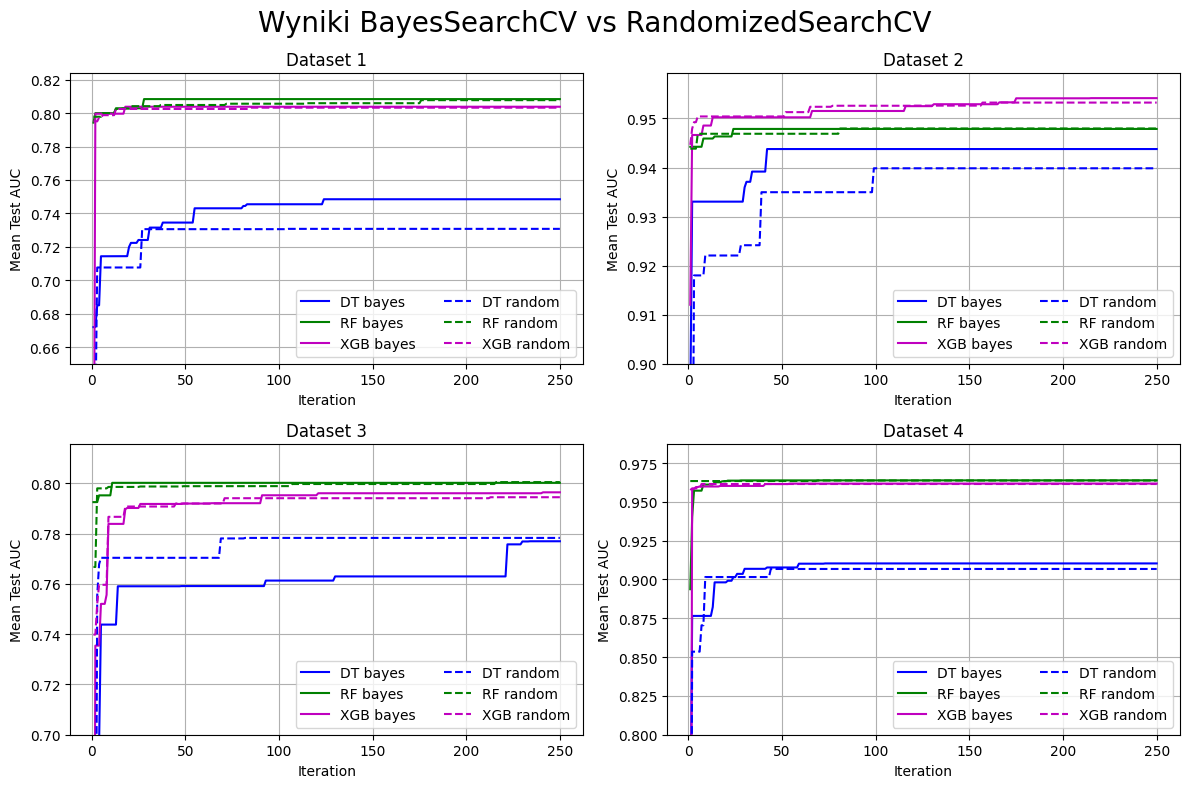

In [476]:
plt.figure(figsize=(12, 8), dpi = 100)

for i in range(N):
    results_dt_random = random_search_dt[i].cv_results_['mean_test_score']
    results_rf_random = random_search_rf[i].cv_results_['mean_test_score']
    results_xgb_random = random_search_xgb[i].cv_results_['mean_test_score']

    results_dt = bayes_search_dt[i].cv_results_['mean_test_score']
    results_rf = bayes_search_rf[i].cv_results_['mean_test_score']
    results_xgb = bayes_search_xgb[i].cv_results_['mean_test_score']

    # Extract relevant information
    iterations = range(1, len(results_dt) + 1)

    # Plot the convergence

    plt.subplot(2, 2, i+1)
    
    plt.plot(iterations, np.maximum.accumulate(results_dt), linestyle='-', color = 'b', label = "DT bayes")
    plt.plot(iterations, np.maximum.accumulate(results_rf), linestyle='-', color = 'g', label = "RF bayes")
    plt.plot(iterations, np.maximum.accumulate(results_xgb), linestyle='-', color = 'm', label = "XGB bayes")

    plt.plot(iterations, np.maximum.accumulate(results_dt_random), linestyle='--', color = 'b', label = "DT random")
    plt.plot(iterations, np.maximum.accumulate(results_rf_random), linestyle='--', color = 'g', label = "RF random")
    plt.plot(iterations, np.maximum.accumulate(results_xgb_random), linestyle='--', color = 'm', label = "XGB random")

    plt.legend(ncol = 2)
    plt.title('Dataset ' + str(i+1))
    plt.xlabel('Iteration')
    plt.ylabel('Mean Test AUC')

    if i == 1:
        y_bottom = 0.9
    elif i == 2:
        y_bottom = 0.7
    elif i == 3:
        y_bottom = 0.8
    else:
        y_bottom = 0.65

    plt.ylim(bottom = y_bottom)
    plt.tight_layout()
    plt.grid(True)

plt.suptitle('Wyniki BayesSearchCV vs RandomizedSearchCV', fontsize=20)
plt.tight_layout()
plt.show()

## Dostrajalność algorytmów

Dostrajalność algorytmów ogółem

In [586]:
tunability_dt = np.mean(calculate_tunability(dt_df, N))
tunability_rf = np.mean(calculate_tunability(rf_df, N))
tunability_xgb = np.mean(calculate_tunability(xgb_df, N))

print(f"DT: {tunability_dt:.5f}")
print(f"RF: {tunability_rf:.5}")
print(f"XGB: {tunability_xgb:.5}")

DT: 0.01866
RF: 0.0092323
XGB: 0.0098488


In [587]:
tunability_dt_g = np.mean(calculate_tunability(dt_df_b, N))
tunability_rf_g = np.mean(calculate_tunability(rf_df_b, N))
tunability_xgb_g = np.mean(calculate_tunability(xgb_df_b, N))

print(f"DT: {tunability_dt_g:.5f}")
print(f"RF: {tunability_rf_g:.5}")
print(f"XGB: {tunability_xgb_g:.5}")

DT: 0.00861
RF: 0.0017998
XGB: 0.0037967


Dostrajalność pojedynczych parametrów

In [585]:
tunability_dt_single = {}
tunability_rf_single = {}
tunability_xgb_single = {}

for p in param_grid_dt.keys():
    tunability_dt_single[p] = np.mean(calculate_tunability(results_oneway_dt[p], N, best_par = best_params(dt_df)))

for p in param_grid_rf.keys():
    tunability_rf_single[p] = np.mean(calculate_tunability(results_oneway_rf[p], N, best_par = best_params(rf_df)))

for p in param_grid_xgb.keys():
    tunability_xgb_single[p] = np.mean(calculate_tunability(results_oneway_xgb[p], N, best_par = best_params(xgb_df)))

pd.DataFrame(pd.DataFrame(tunability_dt_single, index = ["tunability"]))

,criterion,splitter,max_depth,min_samples_split,min_impurity_decrease,ccp_alpha
tunability,0.001065,0.003026,0.002727,0.002045,0.001372,0.003749


In [523]:
pd.DataFrame(pd.DataFrame(tunability_rf_single, index = ["tunability"]))

,criterion,n_estimators,max_depth,min_samples_split,max_features,min_impurity_decrease
tunability,0.0,0.000657,0.007535,0.006305,0.0,0.007586


In [524]:
pd.DataFrame(pd.DataFrame(tunability_xgb_single, index = ["tunability"]))

,n_estimators,max_depth,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda
tunability,0.000627,0.003684,0.001263,0.003004,0.001881,0.007291,0.005931


Wykresy

In [ ]:
var = "criterion"
plt.boxplot([dt_df[dt_df[var] == 'entropy']['auc_avg'], dt_df[dt_df[var] == 'gini']['auc_avg']],
            labels=['entropy', "gini"])

# Add labels and title
plt.xlabel(var)
plt.ylabel('AUC')
plt.title("DT: " + str(var))

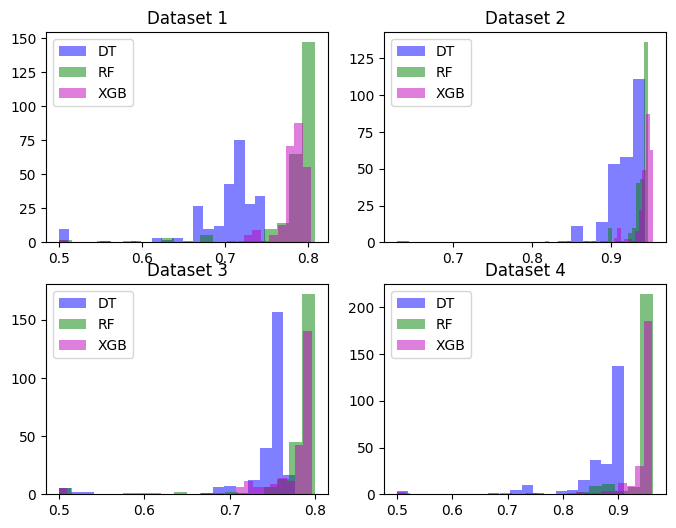

In [568]:
plt.figure(figsize=(8, 6), dpi = 100)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(bayes_search_dt[i].cv_results_["mean_test_score"], color = "b", bins = 20, alpha = 0.5, label = "DT")
    plt.hist(bayes_search_rf[i].cv_results_["mean_test_score"], color = "g", bins = 20, alpha = 0.5, label = "RF")
    plt.hist(bayes_search_xgb[i].cv_results_["mean_test_score"], color = "m", bins = 30, alpha = 0.5, label = "XGB")
    plt.legend()
    plt.title(f"Dataset {i+1}")

In [ ]:
var = "colsample_bytree"
plt.scatter(xgb_df[var], xgb_df["auc_avg"], alpha = 0.5, color = "m")
plt.xscale('log')

plt.xlabel(var)
plt.ylabel('AUC')
plt.title("XGB: " + str(var))

plt.show()


In [588]:
import pickle
data_to_save = {
    "dane_dt_random": dt_df,
    "dane_df_random": rf_df,
    "dane_xgb_random": xgb_df,
    "dane_dt_bayes": dt_df_b,
    "dane_df_bayes": rf_df_b,
    "dane_xgb_bayes": xgb_df_b,
    "dane_dt_pojedyncze": results_oneway_dt,
    "dane_rf_pojedyncze": results_oneway_rf,
    "dane_xgb_pojedyncze": results_oneway_xgb
}

file_path = 'wyniki.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(data_to_save, file)

In [591]:
dt_df

,criterion,splitter,max_depth,min_samples_split,min_impurity_decrease,ccp_alpha,auc_1,auc_2,auc_3,auc_4,auc_avg
0,gini,random,23,0.1,0.000028,0.1,0.500000,0.852984,0.500000,0.500000,0.588246
1,entropy,random,15,0.0001,0.000077,0.000028,0.615274,0.849113,0.590371,0.853493,0.727063
2,entropy,best,14,0.1,0.012915,0.000215,0.707595,0.918006,0.755359,0.814657,0.798904
3,gini,random,4,0.021544,0.000599,0.000599,0.702952,0.901370,0.767830,0.826591,0.799686
4,gini,random,3,0.046416,0.00001,0.000215,0.694143,0.891682,0.770386,0.791996,0.787052
...,...,...,...,...,...,...,...,...,...,...,...
245,gini,random,21,0.001,0.035938,0.000215,0.671905,0.852984,0.500000,0.713400,0.684572
246,gini,random,17,0.002154,0.001668,0.000028,0.663369,0.905764,0.760070,0.821465,0.787667
247,entropy,random,10,0.046416,0.004642,0.000599,0.700607,0.910049,0.766130,0.808621,0.796352
248,entropy,best,5,0.046416,0.1,0.001668,0.500000,0.900254,0.531687,0.743264,0.668802
